In [1]:
#https://www.kaggle.com/code/mathewkouch/ham10000-skin-lesion-classifier-82-pytorch
import torch
import torchvision
import torchvision.transforms as T # data augmentation
import torchvision.models as models # to get pretrained models
import torch.nn as nn # to build NN, criterion
import torch.optim as optim # optimizer

# plotting and evaluation
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix # performance evaluation

# Datapipe Line
import pandas as pd # read csv
from imblearn.over_sampling import RandomOverSampler as ROS # training data oversampling
from sklearn.model_selection import train_test_split # splitting dataframes
from torch.utils.data import Dataset, DataLoader # data pipeline

# utils
import numpy as np
import os
import random
import torch.nn.functional as F # softmax
from tqdm import tqdm # progress visualisation

# Setting device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# For reproducibility
RANDOM_SEED = 42 

def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed(RANDOM_SEED)

Random seed set as 42


In [2]:
lr = 0.001
bs = 128 # On P100, 512 is okay for resnet32 and resnet50, bs 256 is okay for densenet121 and densenet201
EPOCHS = 40 # number of training epochs in total
FT_EPOCHS = 5 # first epochs to fine tune classifier head only, after that end to end finetuning begins
LR_MIN = 1e-6 # minimum learning rate, below that, early training stopping occurs

highest_acc = 0.80 # Manually set for now

# Choose CNN backbone
CNNS = ['resnet34', 'resnet50', 'densenet121', 'densenet201','mix']
CHOSEN_MODEL = CNNS[4] # desnenet121 performs best

# Flags
SAVE_CHECKPOINT = True
SAVE_HIGHEST = True

In [3]:
data = pd.read_csv('./archive/hmnist_28_28_RGB_binary.csv')
data.head()
classes = {1: (['akiec','bcc', 'mel'], 'Cancer'), 
           0:(['df','nv','bkl','vasc'] , 'Not Cancer')
           }
CLASSES = [classes[idx][0] for idx in range(len(classes))] # abbreviated form of classes
CLASSES_FULL = [classes[idx][1] for idx in range(len(classes))] # Full name of classes
CLASSES, CLASSES_FULL 

([['df', 'nv', 'bkl', 'vasc'], ['akiec', 'bcc', 'mel']],
 ['Not Cancer', 'Cancer'])

<ipython-input-4-e7bb6ac0e002>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  x_train.insert(0, 'label', value=y_train.values)


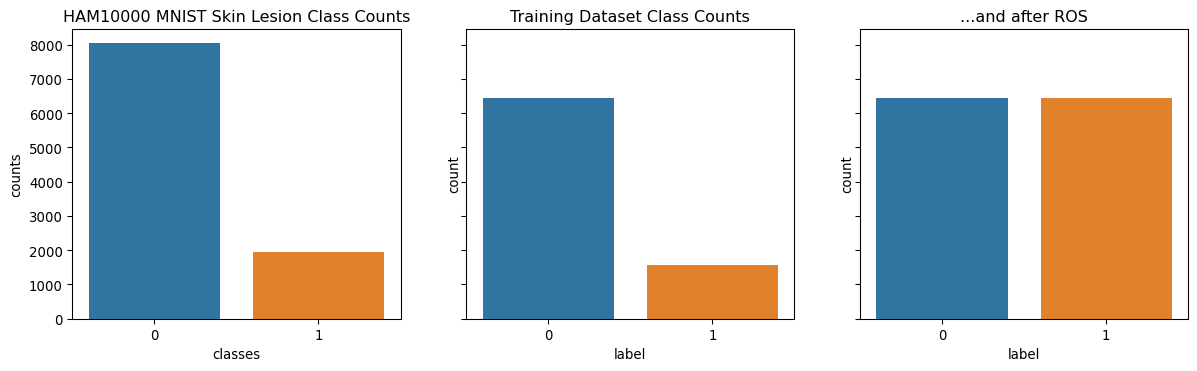

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3, figsize=(15,4), dpi=(96), sharex=True, sharey=True)

# Original dataset
x = data.drop(labels='label', axis=1) # drop the label column
y = data.label # get the label
# Plotting count
sns.countplot(x=data['label'], ax=ax[0])
ax[0].set(xlabel='classes', ylabel='counts')
ax[0].title.set_text('HAM10000 MNIST Skin Lesion Class Counts')


# Split original dataframe to training and testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

# Plot number of samples in train split
x_train_ = x_train.copy()
x_train_.insert(0, 'label', value=y_train.values)
train_df_ = x_train_
sns.countplot(x=train_df_['label'], ax=ax[1])
ax[1].title.set_text('Training Dataset Class Counts')

# Create over sampler, and over sample ONLY the TRAIN dataframe
oversampler = ROS()
x_train, y_train = oversampler.fit_resample(x_train, y_train)

# Combine train image and label dataframe as one dataframe because my dataset requires it
x_train.insert(0, 'label', value=y_train.values)
train_df = x_train

# Combine test image and label dataframe as one dataframe because my dataset requires it
x_test.insert(0, 'label', value=y_test.values)
test_df = x_test

# Print number of samples in each train/test splits
len(train_df), len(test_df)

# Plot number of samples in train split (thats oversampled); all classes should have same number of counts
sns.countplot(x=train_df['label'], ax=ax[2])
ax[2].title.set_text('...and after ROS')
plt.show(block='off')

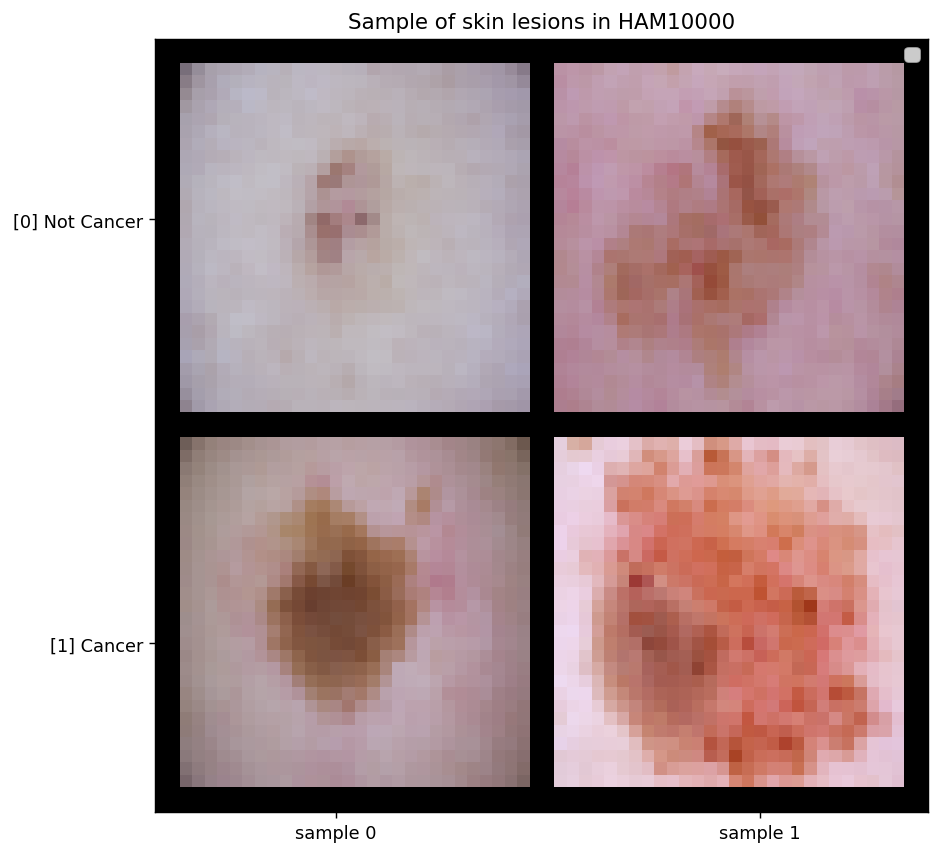

In [5]:
sample_images = []
N = len(CLASSES) # number of samples per class
for class_ in classes.keys():
    image_idxs = data.label==class_
    N_ = len(data[image_idxs])
    chosen = random.sample(list(np.arange(N_)), k= N) # creating random 7 samples per class
    images = np.asarray(data[image_idxs].iloc[chosen,:-1])# grabing those random 7 samples
    
    for img in images:
        sample_images.append(torch.tensor(img.reshape(28,28,3)).permute(2,0,1)) # obtaining one image at a time 
        
s = torch.stack(sample_images) # stack all images, convert to torch.tensor for grid
grid = torchvision.utils.make_grid(s, nrow=N, ncol=N) # create grid with same rows and cols

plt.figure(figsize=(8,8), dpi=(128)) # plot the grid
plt.imshow(grid.permute(1,2,0))
plt.xticks(np.linspace(14,grid.shape[2]-14,2), labels=[f'sample {idx}' for idx in range(N)])
plt.yticks(np.linspace(14,grid.shape[1]-14,2), labels=[f'[{idx}] {cls_}' for idx, cls_ in enumerate(CLASSES_FULL)])
plt.title('Sample of skin lesions in HAM10000')
plt.legend(CLASSES_FULL)
plt.show(block='off')

In [6]:
class HAM10KDS(Dataset): # custom dataset
    def __init__(self, df, transforms=None, selective=True, OR=4, normalised=True):
        self.data = df # the dataframe containing the image
        self.y = self.data.label # label y
        self.x = self.data.drop(labels='label', axis=1) # drop the label, get images
        
        # Reshape the entire image array into N x height x width x RGB channel. N = number of samples
        self.x = np.asarray(self.x).reshape(-1, 28, 28,3)
        
        # Calculate the RGB stats for normalisation, and convert to tensor.
        self.mean = torch.tensor([np.mean(self.x[:, :, :, channel]) for channel in range(3)]).reshape(1, 3, 1, 1) 
        self.std = torch.tensor([np.std(self.x[:, :, :, channel]) for channel in range(3)]).reshape(1, 3, 1, 1)  
        
        # Convert images to torch tensor for transforms and training on GPU. Images will be moved to GPU outside dataloader.
        self.x = torch.tensor(self.x, dtype=torch.float32).permute(0, 3, 1, 2)
        
        # Normalise the images with the stats calculated
        if normalised==True:
            self.x -= self.mean
            self.x /= self.std
        print('images are normalised')
        
        self.resize = T.Resize((28*4, 28*4)) # Increase images by 4 in both dimension.

        self.OR = OR # the label of the over represented class
        self.tf = transforms # the input list of transforms
        self.selective = selective # flag to apply transform to under rep classes only
        
    def __len__(self):
        return len(self.data) # number of samples in dataset
    
    def __getitem__(self,idx):
        label = torch.tensor(self.y.iloc[idx]) # get label of image and convert to torch tensor
        
        img = self.x[idx] # get the image from the big tensor
        img = self.resize(img) # upsize the image
        
        # Applying transforms
        if self.tf!=None:
            if self.selective==True: # Can choose to NOT apply augmentation on over rep classes
                if label.item()!=self.OR: 
                    img = self.tf(img)
            else: # Or just apply aug to ALL classes and samples
                img = self.tf(img)
                                
        return img, label

In [7]:
class CNN(nn.Module): # custom CNN model
    
    def __init__(self, num_classes, model='resnet50'):
        super(CNN, self).__init__()
        
        self.num_classes = num_classes
        print(f'There are {self.num_classes} classes.')
        
        self.chosen_model = model
        
        
        # Choosing backbone CNN
        
        if self.chosen_model=='resnet34':
            
            self.model = models.resnet34(pretrained=True)
            
            self.classifier = nn.Sequential(
                nn.Dropout(p=0.1), # regularisation
                
                # Common practise to set nn.Linear with no bias if using batchnorm after it.
                # As batchnorm normalises activitations from nn.Linear, it also removes the bias from nn.Linear,
                # and it adds its own bias term. Thus, nn.Linear bias term is redundant.
                
                nn.Linear(self.model.fc.in_features, 256, bias=False), 
                nn.ReLU(),
                nn.BatchNorm1d(256),

                nn.Linear(256, 128, bias=False),
                nn.ReLU(),
                nn.BatchNorm1d(128),

                nn.Linear(128, self.num_classes, bias=False),
                nn.BatchNorm1d(self.num_classes), 
            )
            self.model.fc = self.classifier
            
        elif self.chosen_model=='densenet121':
            
            self.model = models.densenet121(pretrained=True)
            
            self.classifier = nn.Sequential(
                nn.Dropout(p=0.1), # regularisation
                
                # Common practise to set nn.Linear with no bias if using batchnorm after it.
                # As batchnorm normalises activitations from nn.Linear, it also removes the bias from nn.Linear,
                # and it adds its own bias term. Thus, nn.Linear bias term is redundant.
                
                nn.Linear(self.model.classifier.in_features, 256, bias=False), 
                nn.ReLU(),
                nn.BatchNorm1d(256),

                nn.Linear(256, 128, bias=False),
                nn.ReLU(),
                nn.BatchNorm1d(128),

                nn.Linear(128, self.num_classes, bias=False),
                nn.BatchNorm1d(self.num_classes), 
            )
            
            self.model.classifier = self.classifier
            
        elif self.chosen_model=='mix':
            
            self.model_a = models.densenet121(pretrained=True) 
            self.model_b = models.resnet34(pretrained=True)
            
            self.classifier = nn.Sequential(
                nn.Dropout(p=0.1), # regularisation
                
                # Common practise to set nn.Linear with no bias if using batchnorm after it.
                # As batchnorm normalises activitations from nn.Linear, it also removes the bias from nn.Linear,
                # and it adds its own bias term. Thus, nn.Linear bias term is redundant.
                
                #nn.Linear(self.model_a.classifier.in_features + self.model_b.fc.in_features, 256, bias=False),
                nn.Linear(2000, 256, bias=False),
                nn.ReLU(),
                nn.BatchNorm1d(256),

 

                nn.Linear(256, 128, bias=False),
                nn.ReLU(),
                nn.BatchNorm1d(128),

 

                nn.Linear(128, self.num_classes, bias=False),
                nn.BatchNorm1d(self.num_classes), 
            )
            
            #self.model.classifier = self.classifier
            
        print(f'{self.chosen_model} created')
        
        #model_parameters = filter(lambda p: p.requires_grad, self.model.parameters())
        #params = sum([np.prod(p.size()) for p in model_parameters])
        #print(f'Model has {params} trainable params.')

    def forward(self, x):
        if self.chosen_model == "mix":
            #print(f"size of x {x.shape}")
            feature_map_a = self.model_a(x)
            feature_map_b = self.model_b(x)
            x = torch.cat((feature_map_a, feature_map_b), dim=1)
            #print(f"size of x after cat {x.shape}")
            #print(f"self.classifier\(x\) {self.classifier(x)}")
            return(self.classifier(x))
        else:
            return(self.model(x))

In [8]:
# Image augmentation only for training
tf = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    T.RandomAffine(degrees=15, 
                   translate=(0.1, 0.1), 
                   scale=(0.9,1.0), 
                   shear=(10))
                   
])

# Create dataset and dataloader for train and test
train_ds = HAM10KDS(train_df, tf, selective=False)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, pin_memory=True, num_workers=2)

test_ds = HAM10KDS(test_df)
test_dl = DataLoader(test_ds, batch_size=bs, shuffle=False, pin_memory=True, num_workers=2)

print('There are ', len(train_ds),' training samples, ', len(test_ds), ' testing samples.')

# Create model with chosen CNN backbone
model = CNN(len(CLASSES), model=CHOSEN_MODEL).to(DEVICE)

# Freezing pretrained CNN backbone for classifier head fine tuning
for p in model.parameters():
    p.requires_grad=False
    
for p in model.classifier.parameters():
    p.requires_grad=True

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.1)

# Weights for weighted cross entropy loss
#class_weights = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0]).to(DEVICE)
#criterion = nn.CrossEntropyLoss(weight=class_weights) # multi class cross enropty loss with softmax built in

# Loss function. Have one for train and test/eval just in case train loss is different.
criterion = nn.CrossEntropyLoss()
eval_criterion = nn.CrossEntropyLoss()

# Reduce lr to 10 percent if test accuracy doesnt improve by 1%
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, threshold=0.0001, threshold_mode='rel', 
                                                       cooldown=0, min_lr=0, eps=1e-08, verbose=True) 

images are normalised
images are normalised
There are  12892  training samples,  2003  testing samples.
There are 2 classes.


/home/abd/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/abd/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/abd/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the

mix created


In [9]:
train_acc = []
train_losses = []

test_acc = []
test_losses = []

lrs = []

# For warmup
lr0 = lr*0.01

lr_step = (lr-lr0)/(len(train_dl)-1) # lr step for slow warm up from lr0 to lr 

print(f'Highest acc to beat: {highest_acc}')
best_acc = 0.90*highest_acc # use to decide whether to save a run 

for epoch in range(EPOCHS):
        loader = tqdm(train_dl)
        losses = [] # logs avg loss per epoch
        accs = [] # logs avg acc per epoch
        correct = 0 # counts how many correct predictions
        count = 0 # counts how many samples
        
        if epoch>0:
            lrs+= [optimizer.param_groups[0]['lr']]*len(train_dl) # track lr after warm up
        
        if epoch==FT_EPOCHS:
            for p in model.parameters():
                p.requires_grad = True
            print('End to End Fine Tuning Begins')

        model.train()
        for bidx, (images, labels) in enumerate(loader):
            
            # Warm up, slowly increase fomr lr0 to lr in first epoch
            if epoch==0:
                    
                lr_ = lr0 + lr_step*bidx

                for op in optimizer.param_groups:
                    op['lr'] = lr_

                lrs.append(optimizer.param_groups[0]['lr']) # track lr

            images = images.to(DEVICE) # move to gpu
            labels = labels.to(DEVICE)
            score = model(images)
            loss = criterion(score, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                pred = torch.argmax(score, -1).detach() # need to detach else bug
                correct += (pred==labels).sum() # count how many correct
                count += len(labels)
                acc = correct/count # accumated accuracy
                
                losses.append(loss.item())
                accs.append(acc)
                
                loader.set_description(f'TRAIN | epoch {epoch+1}/{EPOCHS} | acc {acc:.4f} | loss {loss.item():.4f}')
                
        train_acc.append(acc)
        train_losses.append(torch.tensor(losses).mean().item())
                
        model.eval()
        with torch.no_grad():
            
            loader = tqdm(test_dl)
            
            losses = [] # logs loss per minibatch
            accs = [] # logs running acc throughout one epoch
            
            correct = 0 # counts how many correct predictions in one epoch
            count = 0 # counts how many samples seen in one epoch
            
            for bidx, (images, labels) in enumerate(loader):
                images = images.to(DEVICE) # move to gpu
                labels = labels.to(DEVICE)
                
                score = model(images)
                loss = eval_criterion(score, labels)
                
                pred = torch.argmax(score, -1).detach() # need to detach else bug
                correct += (pred==labels).sum() # count how many correct
                count += len(labels)

                acc = correct/count # accumated accuracy
                loader.set_description(f'TEST | epoch {epoch+1}/{EPOCHS} | acc {acc:.4f} | loss {loss.item():.4f}')
                
                losses.append(loss.item())
                accs.append(acc)

        test_acc.append(acc)
        test_losses.append(torch.tensor(losses).mean().item())
        
        scheduler.step(torch.tensor(acc)) # reduce lr if test acc does not improve
        
        if SAVE_CHECKPOINT==True:
            if test_acc[-1]>best_acc:
                best_acc = test_acc[-1].item()

                checkpoint = {
                    'model': model,
                    'losses': [train_losses, test_losses],
                    'accs': [train_acc, test_acc],
                    'lrs': lrs,
                    'best_acc': best_acc,
                    'last_epoch_trained': epoch,
                }
                
                if best_acc > highest_acc and SAVE_HIGHEST==True:
                    old_highest_acc = highest_acc
                    highest_acc = best_acc
                    torch.save(highest_acc, 'highest_acc.pt')
                    print(f'HIGHEST ACCURACY SURPASSED from {old_highest_acc} to {highest_acc}') # save highest achieving model evahhh (yayyy! ^.^)
                    torch.save(checkpoint, f'{highest_acc:.4f} checkpoint.pt')

                torch.save(checkpoint, 'checkpoint.pt')
                print(f'Checkpointed with {best_acc:.4f} best acc')
            
        if optimizer.param_groups[0]['lr']<LR_MIN:
            print(f'EARLY STOPPING! LR below {LR_MIN}')
            break

Highest acc to beat: 0.8


TRAIN | epoch 1/40 | acc 0.7404 | loss 0.4457: 100%|██████████| 101/101 [00:09<00:00, 10.20it/s]
TEST | epoch 1/40 | acc 0.6835 | loss 0.5609: 100%|██████████| 16/16 [00:01<00:00, 11.97it/s]
<ipython-input-9-c0c404e51e3e>:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scheduler.step(torch.tensor(acc)) # reduce lr if test acc does not improve
TRAIN | epoch 2/40 | acc 0.7894 | loss 0.4638: 100%|██████████| 101/101 [00:08<00:00, 11.69it/s]
TEST | epoch 2/40 | acc 0.7169 | loss 0.4783: 100%|██████████| 16/16 [00:01<00:00, 12.10it/s]
TRAIN | epoch 3/40 | acc 0.8007 | loss 0.4213: 100%|██████████| 101/101 [00:08<00:00, 12.02it/s]
TEST | epoch 3/40 | acc 0.6580 | loss 0.5776: 100%|██████████| 16/16 [00:01<00:00, 11.83it/s]
TRAIN | epoch 4/40 | acc 0.8076 | loss 0.3834: 100%|██████████| 101/101 [00:08<00:00, 11.75it/s]
TEST | epoch 4/40 | ac

Checkpointed with 0.7409 best acc


  0%|          | 0/101 [00:00<?, ?it/s]

End to End Fine Tuning Begins


TRAIN | epoch 6/40 | acc 0.7998 | loss 0.4001: 100%|██████████| 101/101 [00:28<00:00,  3.54it/s]
TEST | epoch 6/40 | acc 0.7688 | loss 0.4546: 100%|██████████| 16/16 [00:01<00:00, 11.63it/s]


Checkpointed with 0.7688 best acc


TRAIN | epoch 7/40 | acc 0.8256 | loss 0.3910: 100%|██████████| 101/101 [00:28<00:00,  3.49it/s]
TEST | epoch 7/40 | acc 0.8502 | loss 0.6002: 100%|██████████| 16/16 [00:01<00:00, 11.81it/s]


HIGHEST ACCURACY SURPASSED from 0.8 to 0.8502246737480164
Checkpointed with 0.8502 best acc


TRAIN | epoch 8/40 | acc 0.8342 | loss 0.3345: 100%|██████████| 101/101 [00:28<00:00,  3.55it/s]
TEST | epoch 8/40 | acc 0.8048 | loss 0.4600: 100%|██████████| 16/16 [00:01<00:00, 11.89it/s]
TRAIN | epoch 9/40 | acc 0.8483 | loss 0.2997: 100%|██████████| 101/101 [00:28<00:00,  3.52it/s]
TEST | epoch 9/40 | acc 0.8357 | loss 0.3970: 100%|██████████| 16/16 [00:01<00:00, 12.07it/s]
TRAIN | epoch 10/40 | acc 0.8537 | loss 0.2627: 100%|██████████| 101/101 [00:28<00:00,  3.54it/s]
TEST | epoch 10/40 | acc 0.7923 | loss 0.5286: 100%|██████████| 16/16 [00:01<00:00, 11.86it/s]
TRAIN | epoch 11/40 | acc 0.8619 | loss 0.2906: 100%|██████████| 101/101 [00:28<00:00,  3.53it/s]
TEST | epoch 11/40 | acc 0.8487 | loss 0.3437: 100%|██████████| 16/16 [00:01<00:00, 12.04it/s]


Epoch 00011: reducing learning rate of group 0 to 1.0000e-04.


TRAIN | epoch 12/40 | acc 0.8913 | loss 0.2538: 100%|██████████| 101/101 [00:29<00:00,  3.40it/s]
TEST | epoch 12/40 | acc 0.8447 | loss 0.3415: 100%|██████████| 16/16 [00:01<00:00, 11.85it/s]
TRAIN | epoch 13/40 | acc 0.9032 | loss 0.2453: 100%|██████████| 101/101 [00:28<00:00,  3.54it/s]
TEST | epoch 13/40 | acc 0.8462 | loss 0.3379: 100%|██████████| 16/16 [00:01<00:00, 11.59it/s]
TRAIN | epoch 14/40 | acc 0.9187 | loss 0.2644: 100%|██████████| 101/101 [00:28<00:00,  3.52it/s]
TEST | epoch 14/40 | acc 0.8512 | loss 0.3838: 100%|██████████| 16/16 [00:01<00:00, 11.81it/s]


HIGHEST ACCURACY SURPASSED from 0.8502246737480164 to 0.8512231707572937
Checkpointed with 0.8512 best acc


TRAIN | epoch 15/40 | acc 0.9269 | loss 0.2229: 100%|██████████| 101/101 [00:28<00:00,  3.55it/s]
TEST | epoch 15/40 | acc 0.8597 | loss 0.3524: 100%|██████████| 16/16 [00:01<00:00, 11.80it/s]


HIGHEST ACCURACY SURPASSED from 0.8512231707572937 to 0.8597104549407959
Checkpointed with 0.8597 best acc


TRAIN | epoch 16/40 | acc 0.9299 | loss 0.1867: 100%|██████████| 101/101 [00:29<00:00,  3.46it/s]
TEST | epoch 16/40 | acc 0.8527 | loss 0.3387: 100%|██████████| 16/16 [00:01<00:00, 11.39it/s]
TRAIN | epoch 17/40 | acc 0.9377 | loss 0.1482: 100%|██████████| 101/101 [00:30<00:00,  3.30it/s]
TEST | epoch 17/40 | acc 0.8497 | loss 0.3692: 100%|██████████| 16/16 [00:01<00:00, 11.42it/s]
TRAIN | epoch 18/40 | acc 0.9441 | loss 0.1738: 100%|██████████| 101/101 [00:30<00:00,  3.30it/s]
TEST | epoch 18/40 | acc 0.8622 | loss 0.3313: 100%|██████████| 16/16 [00:01<00:00, 11.30it/s]


HIGHEST ACCURACY SURPASSED from 0.8597104549407959 to 0.8622066974639893
Checkpointed with 0.8622 best acc


TRAIN | epoch 19/40 | acc 0.9511 | loss 0.1790: 100%|██████████| 101/101 [00:30<00:00,  3.29it/s]
TEST | epoch 19/40 | acc 0.8582 | loss 0.3505: 100%|██████████| 16/16 [00:01<00:00, 11.41it/s]
TRAIN | epoch 20/40 | acc 0.9559 | loss 0.1868: 100%|██████████| 101/101 [00:30<00:00,  3.30it/s]
TEST | epoch 20/40 | acc 0.8677 | loss 0.4035: 100%|██████████| 16/16 [00:01<00:00, 11.23it/s]


HIGHEST ACCURACY SURPASSED from 0.8622066974639893 to 0.8676984310150146
Checkpointed with 0.8677 best acc


TRAIN | epoch 21/40 | acc 0.9563 | loss 0.1827: 100%|██████████| 101/101 [00:30<00:00,  3.29it/s]
TEST | epoch 21/40 | acc 0.8687 | loss 0.3822: 100%|██████████| 16/16 [00:01<00:00, 11.32it/s]


HIGHEST ACCURACY SURPASSED from 0.8676984310150146 to 0.868696928024292
Checkpointed with 0.8687 best acc


TRAIN | epoch 22/40 | acc 0.9582 | loss 0.1857: 100%|██████████| 101/101 [00:30<00:00,  3.30it/s]
TEST | epoch 22/40 | acc 0.8732 | loss 0.3283: 100%|██████████| 16/16 [00:01<00:00, 11.37it/s]


HIGHEST ACCURACY SURPASSED from 0.868696928024292 to 0.8731902241706848
Checkpointed with 0.8732 best acc


TRAIN | epoch 23/40 | acc 0.9613 | loss 0.1121: 100%|██████████| 101/101 [00:30<00:00,  3.30it/s]
TEST | epoch 23/40 | acc 0.8682 | loss 0.3149: 100%|██████████| 16/16 [00:01<00:00, 11.38it/s]
TRAIN | epoch 24/40 | acc 0.9684 | loss 0.0720: 100%|██████████| 101/101 [00:30<00:00,  3.29it/s]
TEST | epoch 24/40 | acc 0.8692 | loss 0.3302: 100%|██████████| 16/16 [00:01<00:00, 11.18it/s]
TRAIN | epoch 25/40 | acc 0.9700 | loss 0.2070: 100%|██████████| 101/101 [00:30<00:00,  3.30it/s]
TEST | epoch 25/40 | acc 0.8672 | loss 0.3186: 100%|██████████| 16/16 [00:01<00:00, 11.27it/s]
TRAIN | epoch 26/40 | acc 0.9711 | loss 0.1165: 100%|██████████| 101/101 [00:30<00:00,  3.29it/s]
TEST | epoch 26/40 | acc 0.8767 | loss 0.3034: 100%|██████████| 16/16 [00:01<00:00, 11.11it/s]


HIGHEST ACCURACY SURPASSED from 0.8731902241706848 to 0.8766849637031555
Checkpointed with 0.8767 best acc


TRAIN | epoch 27/40 | acc 0.9737 | loss 0.1084: 100%|██████████| 101/101 [00:30<00:00,  3.29it/s]
TEST | epoch 27/40 | acc 0.8652 | loss 0.3466: 100%|██████████| 16/16 [00:01<00:00, 11.32it/s]
TRAIN | epoch 28/40 | acc 0.9736 | loss 0.1035: 100%|██████████| 101/101 [00:30<00:00,  3.30it/s]
TEST | epoch 28/40 | acc 0.8742 | loss 0.3822: 100%|██████████| 16/16 [00:01<00:00, 11.36it/s]
TRAIN | epoch 29/40 | acc 0.9784 | loss 0.0785: 100%|██████████| 101/101 [00:30<00:00,  3.29it/s]
TEST | epoch 29/40 | acc 0.8712 | loss 0.2999: 100%|██████████| 16/16 [00:01<00:00, 11.41it/s]
TRAIN | epoch 30/40 | acc 0.9784 | loss 0.1097: 100%|██████████| 101/101 [00:30<00:00,  3.29it/s]
TEST | epoch 30/40 | acc 0.8787 | loss 0.3028: 100%|██████████| 16/16 [00:01<00:00, 11.34it/s]


HIGHEST ACCURACY SURPASSED from 0.8766849637031555 to 0.8786819577217102
Checkpointed with 0.8787 best acc


TRAIN | epoch 31/40 | acc 0.9789 | loss 0.1430: 100%|██████████| 101/101 [00:30<00:00,  3.29it/s]
TEST | epoch 31/40 | acc 0.8752 | loss 0.3359: 100%|██████████| 16/16 [00:01<00:00, 11.42it/s]
TRAIN | epoch 32/40 | acc 0.9806 | loss 0.1375: 100%|██████████| 101/101 [00:29<00:00,  3.45it/s]
TEST | epoch 32/40 | acc 0.8862 | loss 0.3282: 100%|██████████| 16/16 [00:01<00:00, 11.82it/s]


HIGHEST ACCURACY SURPASSED from 0.8786819577217102 to 0.8861707448959351
Checkpointed with 0.8862 best acc


TRAIN | epoch 33/40 | acc 0.9799 | loss 0.0996: 100%|██████████| 101/101 [00:30<00:00,  3.29it/s]
TEST | epoch 33/40 | acc 0.8807 | loss 0.3101: 100%|██████████| 16/16 [00:01<00:00, 11.32it/s]
TRAIN | epoch 34/40 | acc 0.9830 | loss 0.1285: 100%|██████████| 101/101 [00:30<00:00,  3.29it/s]
TEST | epoch 34/40 | acc 0.8782 | loss 0.3096: 100%|██████████| 16/16 [00:01<00:00, 11.27it/s]
TRAIN | epoch 35/40 | acc 0.9824 | loss 0.1025: 100%|██████████| 101/101 [00:30<00:00,  3.29it/s]
TEST | epoch 35/40 | acc 0.8817 | loss 0.2872: 100%|██████████| 16/16 [00:01<00:00, 11.26it/s]
TRAIN | epoch 36/40 | acc 0.9833 | loss 0.1341: 100%|██████████| 101/101 [00:30<00:00,  3.29it/s]
TEST | epoch 36/40 | acc 0.8847 | loss 0.2536: 100%|██████████| 16/16 [00:01<00:00, 11.28it/s]


Epoch 00036: reducing learning rate of group 0 to 1.0000e-05.


TRAIN | epoch 37/40 | acc 0.9869 | loss 0.0843: 100%|██████████| 101/101 [00:30<00:00,  3.29it/s]
TEST | epoch 37/40 | acc 0.8837 | loss 0.2467: 100%|██████████| 16/16 [00:01<00:00, 11.26it/s]
TRAIN | epoch 38/40 | acc 0.9895 | loss 0.0513: 100%|██████████| 101/101 [00:30<00:00,  3.29it/s]
TEST | epoch 38/40 | acc 0.8857 | loss 0.2617: 100%|██████████| 16/16 [00:01<00:00, 11.29it/s]
TRAIN | epoch 39/40 | acc 0.9912 | loss 0.0800: 100%|██████████| 101/101 [00:30<00:00,  3.29it/s]
TEST | epoch 39/40 | acc 0.8877 | loss 0.2574: 100%|██████████| 16/16 [00:01<00:00, 11.23it/s]


HIGHEST ACCURACY SURPASSED from 0.8861707448959351 to 0.8876684904098511
Checkpointed with 0.8877 best acc


TRAIN | epoch 40/40 | acc 0.9915 | loss 0.0779: 100%|██████████| 101/101 [00:30<00:00,  3.30it/s]
TEST | epoch 40/40 | acc 0.8867 | loss 0.2299: 100%|██████████| 16/16 [00:01<00:00, 11.31it/s]


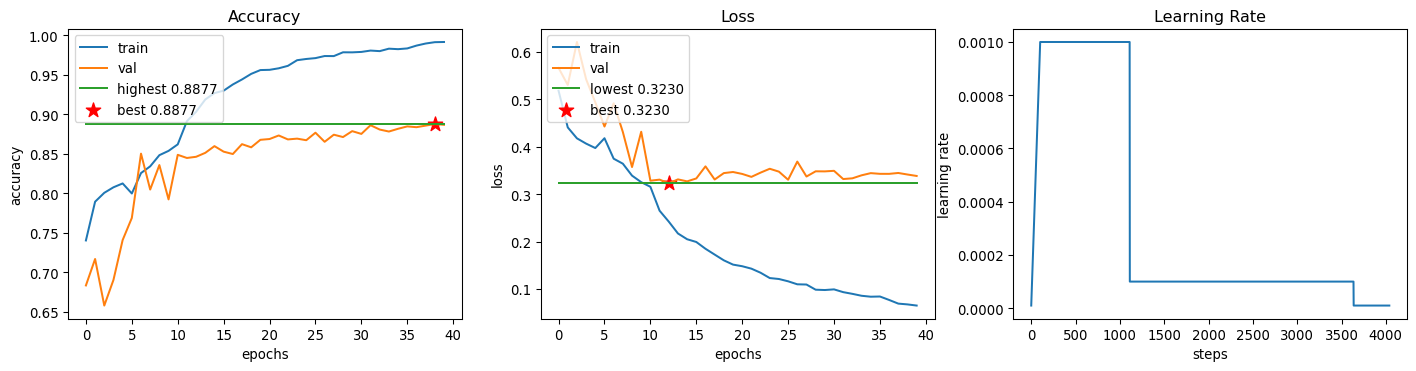

In [10]:
fig, ax = plt.subplots(1,3, figsize=(18,4), dpi=(96))

# Plotting accuracies
ax[0].plot(torch.stack(train_acc).cpu())
ax[0].plot(torch.stack(test_acc).cpu())
ax[0].plot([highest_acc]*(len(train_acc)))
ax[0].scatter(torch.argmax(torch.tensor(test_acc)).item(), torch.tensor(test_acc).max().item(), s=128, c='red', marker='*')
           
ax[0].title.set_text('Accuracy')
ax[0].set(xlabel='epochs', ylabel='accuracy')
ax[0].legend(['train', 'val', f'highest {highest_acc:.4f}', f'best {best_acc:.4f}'], loc='upper left')

# Plotting losses
ax[1].plot(train_losses)
ax[1].plot(test_losses)
ax[1].plot([torch.tensor(test_losses).min()]*len(test_losses))
ax[1].scatter(torch.argmin(torch.tensor(test_losses)).item(), torch.tensor(test_losses).min().item(), s=128, c='red', marker='*')


ax[1].title.set_text('Loss')
ax[1].set(xlabel='epochs', ylabel='loss')
ax[1].legend(['train', 'val', f'lowest {torch.tensor(test_losses).min().item():.4f}', f'best {torch.tensor(test_losses).min().item():.4f}'], loc='upper left')

# Plot learning rate
ax[2].plot(lrs)
ax[2].title.set_text('Learning Rate')
ax[2].set(xlabel='steps', ylabel='learning rate')

plt.show(block='off')

In [11]:
# Load best accuracy checkpoint
best_model_check_point = torch.load('checkpoint.pt', map_location=DEVICE)
best_model = best_model_check_point['model']

# logging preds and actual for confusion matrix
preds = [] # logs model prediction each is a scalar
pred_prob = [] # logs model predictions as 7 dim prob vector
actual = [] # logs actual labels

criterion = nn.CrossEntropyLoss()

loader = tqdm(test_dl)

# Evaluate over test/val set for model prediction

best_model.eval()
with torch.no_grad():
    count = 0
    correct = 0
    losses = 0
    
    for bidx, (images, labels) in enumerate(loader):
        images = images.to(DEVICE)

        actual.append(torch.flatten(labels)) # appends the labels. Flatten to remove batch dimension
        
        labels = labels.to(DEVICE)
        
        score = best_model(images) # scores of B x 7
        
        prob = F.softmax(score, dim=-1) # normalise the scores as prob
       
        pred = torch.argmax(score, dim=-1)
        
        preds.append(torch.flatten(pred))
        
        correct += (pred==labels).sum()
        
        count += len(labels)
        
        pred_prob.append(torch.flatten(prob))
        
        loss = eval_criterion(score, labels)
        
        losses += loss.item()
        
    print(f'ACC: {correct/count:.4f} | LOSS: {losses/len(test_dl)}')

100%|██████████| 16/16 [00:01<00:00, 11.63it/s]

ACC: 0.8877 | LOSS: 0.3415881618857384


In [12]:
# Reformating prediction and actual for confusion matrix
for idx, p in enumerate(preds):
    if idx>0:
        preds_ = torch.cat([preds_, p], dim=0)
    else:
        preds_ = p
        
for idx, p in enumerate(actual):
    if idx>0:
        actual_ = torch.cat([actual_, p], dim=0)
    else:
        actual_ = p
        
conf_mat = confusion_matrix(actual_.cpu(), preds_.cpu()) # confusion matrix

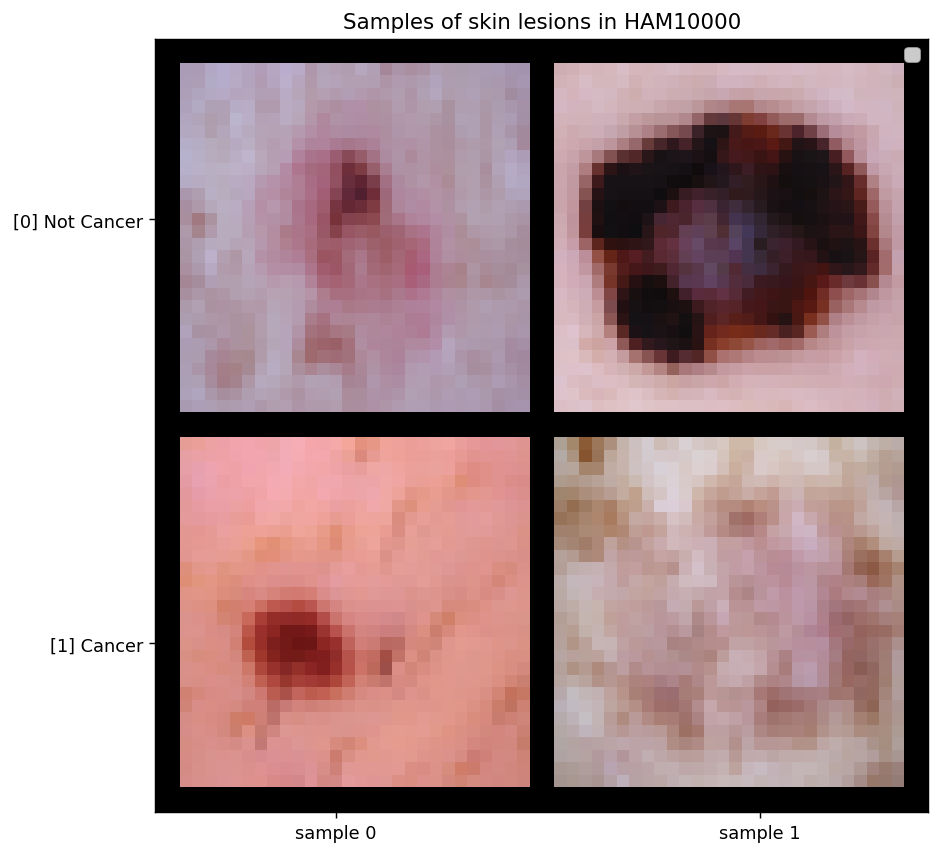

In [13]:
# Showing sample images again for comparison
sample_images = []
N = len(CLASSES) # number of samples per class
for class_ in classes.keys():
    image_idxs = data.label==class_
    N_ = len(data[image_idxs])
    chosen = random.sample(list(np.arange(N_)), k= N) # creating random 7 samples per class
    images = np.asarray(data[image_idxs].iloc[chosen,:-1])# grabing those random 7 samples
    
    for img in images:
        sample_images.append(torch.tensor(img.reshape(28,28,3)).permute(2,0,1)) # obtaining one image at a time 
        
s = torch.stack(sample_images) # stack all images, convert to torch.tensor for grid
grid = torchvision.utils.make_grid(s, nrow=2, ncol=N) # create grid with same rows and cols

plt.figure(figsize=(8,8), dpi=(128)) # plot the grid
plt.imshow(grid.permute(1,2,0))
plt.xticks(np.linspace(14,grid.shape[2]-14,2), labels=[f'sample {idx}' for idx in range(N)])
plt.yticks(np.linspace(14,grid.shape[1]-14,2), labels=[f'[{idx}] {cls}' for idx, cls in enumerate(CLASSES_FULL)])
plt.title('Samples of skin lesions in HAM10000')
plt.legend(CLASSES_FULL)
plt.show(block='off')

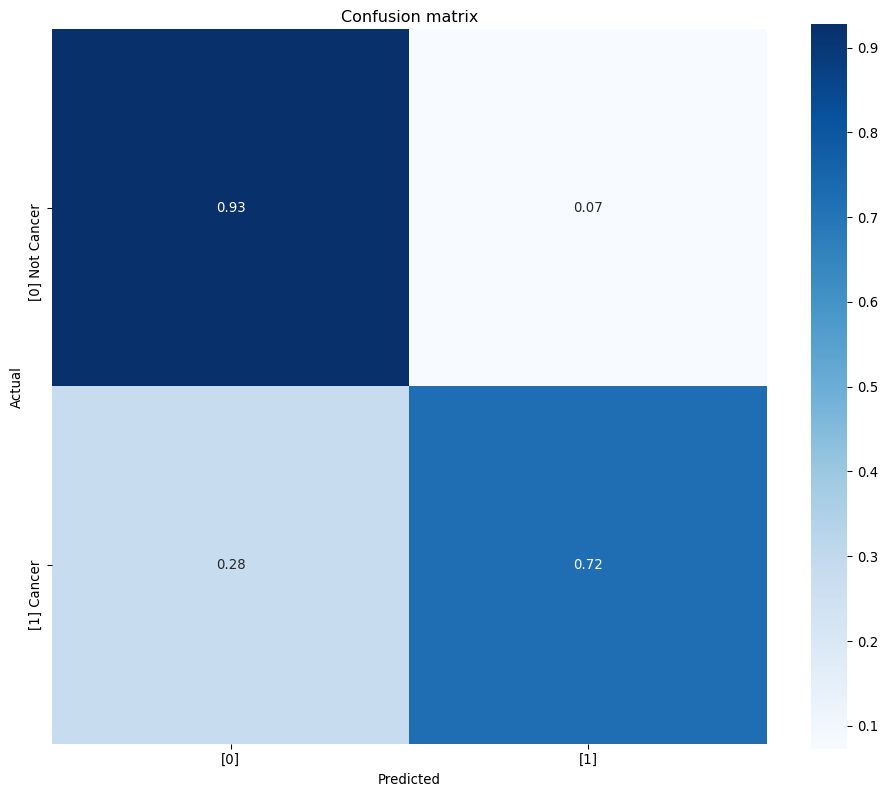

In [14]:
# Plot confusion matrix
cmn = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis] # Normalise to convert count to percentage of counts
fig, ax = plt.subplots(figsize=(12,10), dpi=(96))

plt.imshow(cmn, interpolation='nearest', cmap=plt.cm.Blues)

sns.heatmap(cmn, cmap='Blues', annot=True, fmt='.2f', xticklabels=[f'[{idx}]' for idx in range(len(CLASSES))], yticklabels=[f'[{idx}] {cls}' for idx, cls in enumerate(CLASSES_FULL)])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.show(block=False)